In [1]:
# %%
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For NLP processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# For topic modeling
from gensim import corpora, models

# For visualization of topics
from wordcloud import WordCloud

# For statistical analysis
from scipy.stats import (
    chi2_contingency, chi2, ttest_ind, mannwhitneyu,
    entropy, ks_2samp
)

# For embeddings and similarity calculations
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Data loading
from analysis.beerdata_loader import BeerDataLoader

# To show progress
from tqdm import tqdm

import os
import pickle

from gensim.models import LdaModel
from gensim.corpora import Dictionary

tqdm.pandas()

c:\Users\danil\Documents\Github\ada-2024-project-data-crusadas\venv310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Data Loading and Preprocessing

In [2]:
# Load data
data_loader = BeerDataLoader(
    data_dir="../ada-2024-project-data-crusadas/data/BeerAdvocate",
    force_process=False
)
ba_reviews_df, _, ba_beers_df, _, _ = data_loader.load_all_data()

# Ensure necessary NLTK data is downloaded
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('vader_lexicon', quiet=True)

Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\reviews_processed.csv' already exists. Skipping processing.
Processed file '../ada-2024-project-data-crusadas/data/BeerAdvocate\ratings_processed.csv' already exists. Skipping processing.


True

## 2. Selecting Beers and Limiting Reviews

In [3]:
# Filter for IPA beers
ipa_styles = [
    'American IPA', 'English India Pale Ale (IPA)',
    'Belgian IPA', 'American Double / Imperial IPA'
]

# Filter for IPA styles
ipa_reviews_df = ba_reviews_df[ba_reviews_df['style'].isin(ipa_styles)].copy()
ipa_reviews_df.reset_index(drop=True, inplace=True)

print("Total number of IPA reviews:", len(ipa_reviews_df))

# For non-IPA reviews
non_ipa_reviews_df = ba_reviews_df[~ba_reviews_df['style'].isin(ipa_styles)].copy()
non_ipa_reviews_df.reset_index(drop=True, inplace=True)

Total number of IPA reviews: 476963


In [4]:
# Set parameters
review_threshold = 100  # Minimum number of reviews a beer must have
max_reviews_per_beer = 1000  # Maximum number of reviews to process per beer
sample_size = 100000  # Total reviews to process per category

# For IPA reviews
ipa_review_counts = ipa_reviews_df['beer_id'].value_counts()
ipa_beers_selected = ipa_review_counts[ipa_review_counts >= review_threshold].index.tolist()

ipa_reviews_filtered = ipa_reviews_df[ipa_reviews_df['beer_id'].isin(ipa_beers_selected)]
ipa_reviews_filtered = ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

# For Non-IPA reviews
non_ipa_review_counts = non_ipa_reviews_df['beer_id'].value_counts()
non_ipa_beers_selected = non_ipa_review_counts[non_ipa_review_counts >= review_threshold].index.tolist()

non_ipa_reviews_filtered = non_ipa_reviews_df[non_ipa_reviews_df['beer_id'].isin(non_ipa_beers_selected)]
non_ipa_reviews_filtered = non_ipa_reviews_filtered.groupby('beer_id').head(max_reviews_per_beer).reset_index(drop=True)

# Sample to reduce data size
ipa_reviews_filtered = ipa_reviews_filtered.sample(n=sample_size, random_state=42)
non_ipa_reviews_filtered = non_ipa_reviews_filtered.sample(n=sample_size, random_state=42)

print("Total number of selected IPA reviews:", len(ipa_reviews_filtered))
print("Total number of selected Non-IPA reviews:", len(non_ipa_reviews_filtered))

Total number of selected IPA reviews: 100000
Total number of selected Non-IPA reviews: 100000


## 3. Preprocessing Text Data

In [5]:
# Initialize stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return []
    # Lowercase
    text = text.lower()
    # Tokenize with preserve_line=True to avoid sent_tokenize
    tokens = word_tokenize(text, preserve_line=True)
    # Remove punctuation and non-alphabetic tokens
    tokens = [word for word in tokens if word.isalpha()]
    # Remove stop words
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(word, pos='v') for word in tokens]
    return tokens

# Apply preprocessing
print("Preprocessing IPA reviews...")
ipa_reviews_filtered['tokens'] = ipa_reviews_filtered['text'].progress_apply(preprocess_text)

print("Preprocessing Non-IPA reviews...")
non_ipa_reviews_filtered['tokens'] = non_ipa_reviews_filtered['text'].progress_apply(preprocess_text)

# Remove entries with empty tokens
ipa_reviews_filtered = ipa_reviews_filtered[ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)
non_ipa_reviews_filtered = non_ipa_reviews_filtered[non_ipa_reviews_filtered['tokens'].str.len() > 0].reset_index(drop=True)

print(f"Total IPA reviews after preprocessing: {len(ipa_reviews_filtered)}")
print(f"Total Non-IPA reviews after preprocessing: {len(non_ipa_reviews_filtered)}")

Preprocessing IPA reviews...


100%|██████████| 100000/100000 [00:58<00:00, 1699.65it/s]


Preprocessing Non-IPA reviews...


100%|██████████| 100000/100000 [00:55<00:00, 1816.79it/s]


Total IPA reviews after preprocessing: 99999
Total Non-IPA reviews after preprocessing: 100000


## 4. Topic Modeling with LDA

In [6]:
# Function to perform LDA topic modeling
def perform_lda(tokens_list, num_topics=5):
    # Create dictionary and corpus
    dictionary = Dictionary(tokens_list)
    corpus = [dictionary.doc2bow(tokens) for tokens in tokens_list]
    # Build LDA model
    lda_model = LdaModel(
        corpus=corpus, id2word=dictionary,
        num_topics=num_topics, random_state=42, passes=10
    )
    return lda_model, corpus, dictionary

# Perform LDA on IPA reviews
print("Performing LDA on IPA reviews...")
ipa_tokens_list = ipa_reviews_filtered['tokens'].tolist()
ipa_lda_model, ipa_corpus, ipa_dictionary = perform_lda(ipa_tokens_list, num_topics=5)

# Perform LDA on Non-IPA reviews
print("Performing LDA on Non-IPA reviews...")
non_ipa_tokens_list = non_ipa_reviews_filtered['tokens'].tolist()
non_ipa_lda_model, non_ipa_corpus, non_ipa_dictionary = perform_lda(non_ipa_tokens_list, num_topics=5)

Performing LDA on IPA reviews...
Performing LDA on Non-IPA reviews...


## 5. Visualizing Topics with Word Clouds

Visualizing IPA topics...


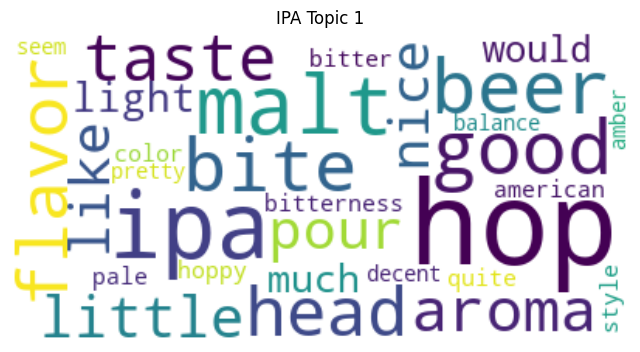

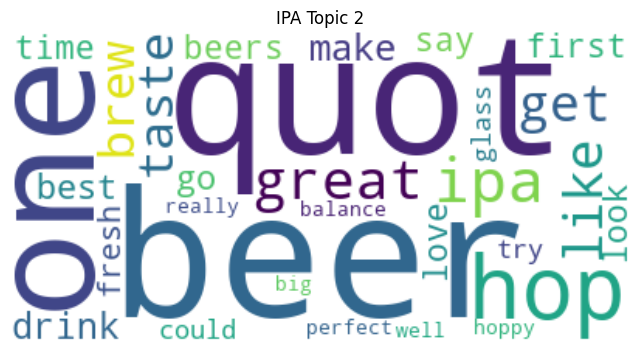

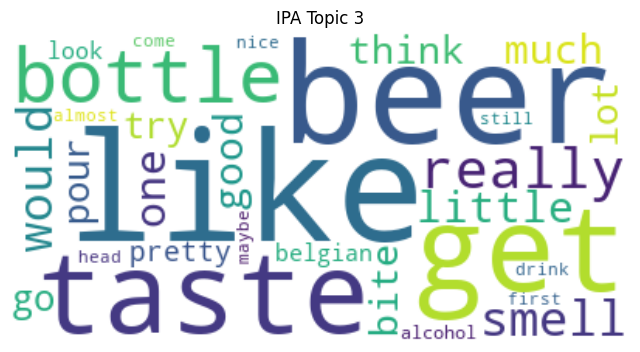

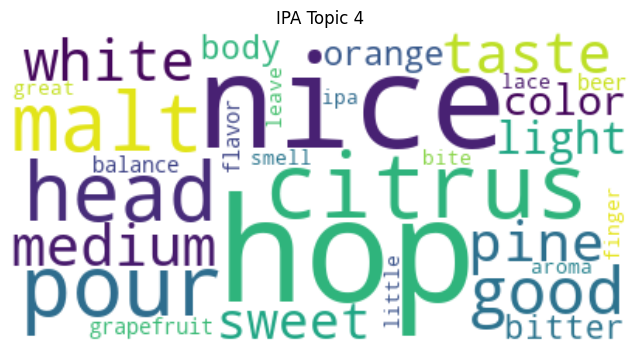

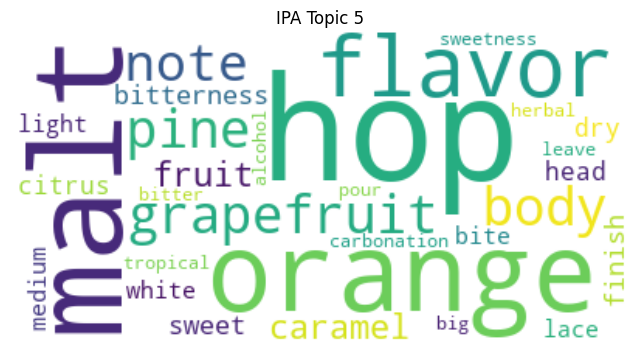

Visualizing Non-IPA topics...


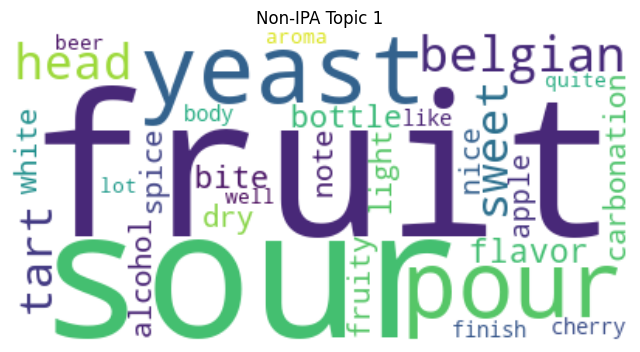

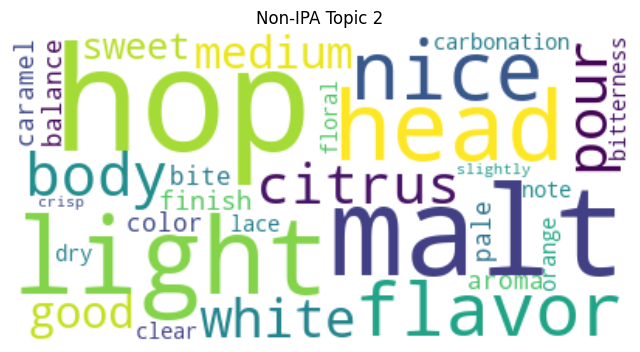

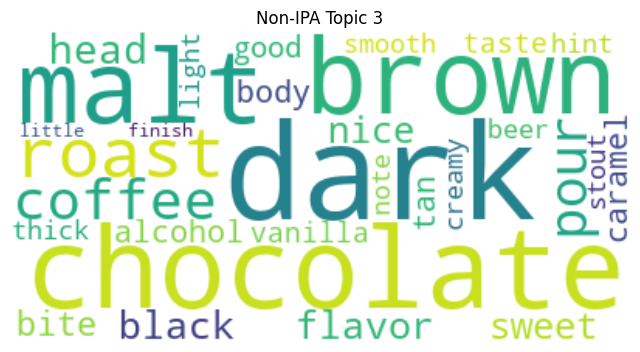

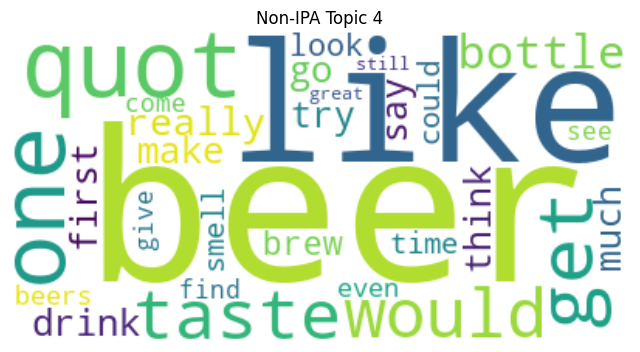

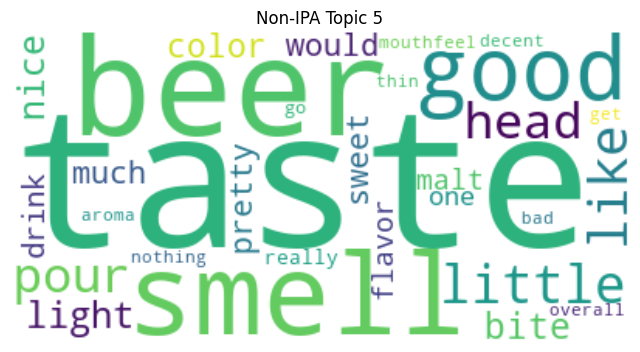

In [7]:
# Function to visualize topics
def visualize_topics(lda_model, num_topics=5, title_prefix=''):
    for i in range(num_topics):
        plt.figure(figsize=(8, 6))
        plt.title(f"{title_prefix} Topic {i+1}")
        words = dict(lda_model.show_topic(i, topn=30))
        wordcloud = WordCloud(background_color='white').generate_from_frequencies(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()

# Visualize IPA topics
print("Visualizing IPA topics...")
visualize_topics(ipa_lda_model, num_topics=5, title_prefix='IPA')

# Visualize Non-IPA topics
print("Visualizing Non-IPA topics...")
visualize_topics(non_ipa_lda_model, num_topics=5, title_prefix='Non-IPA')

## 6. Comparing Common Words and Flavors

In [8]:
# Combine all tokens for IPA and Non-IPA
ipa_all_tokens = [token for tokens in ipa_tokens_list for token in tokens]
non_ipa_all_tokens = [token for tokens in non_ipa_tokens_list for token in tokens]

# Function to get top N words
def get_top_n_words(tokens, n=20):
    freq_dist = nltk.FreqDist(tokens)
    return freq_dist.most_common(n)

# Get top words for IPA and Non-IPA
ipa_top_words = get_top_n_words(ipa_all_tokens, n=20)
non_ipa_top_words = get_top_n_words(non_ipa_all_tokens, n=20)

print("Top words in IPA reviews:")
print(ipa_top_words)

print("\nTop words in Non-IPA reviews:")
print(non_ipa_top_words)

Top words in IPA reviews:
[('hop', 157609), ('beer', 81268), ('malt', 76239), ('nice', 68435), ('head', 66238), ('pour', 64604), ('citrus', 60852), ('good', 59957), ('taste', 59037), ('ipa', 52763), ('flavor', 52011), ('like', 50562), ('bite', 47519), ('one', 44053), ('sweet', 42717), ('light', 41617), ('orange', 40866), ('pine', 40695), ('bitter', 40570), ('body', 39224)]

Top words in Non-IPA reviews:
[('beer', 96624), ('head', 68288), ('malt', 68215), ('pour', 66826), ('taste', 65202), ('light', 57672), ('nice', 57625), ('flavor', 57598), ('hop', 56972), ('like', 56674), ('dark', 53150), ('good', 52772), ('sweet', 50049), ('bite', 48647), ('one', 42231), ('little', 39556), ('body', 38698), ('bottle', 38529), ('smell', 37967), ('color', 35166)]


## 7. Visualizing Top Words

Word Cloud for IPA Top Words:


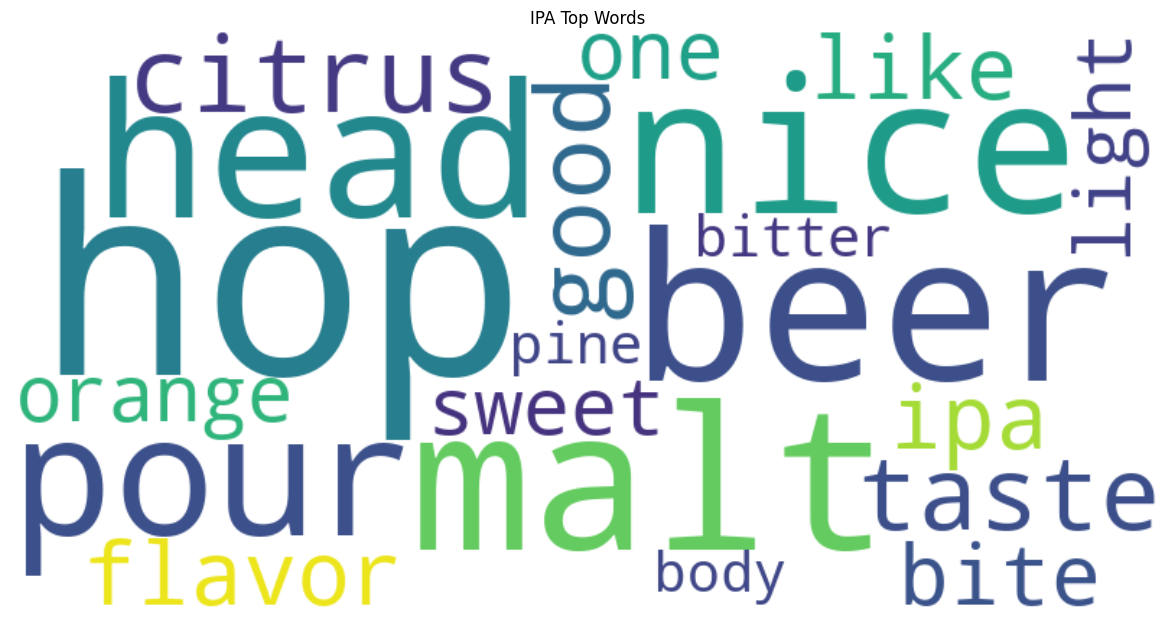

Word Cloud for Non-IPA Top Words:


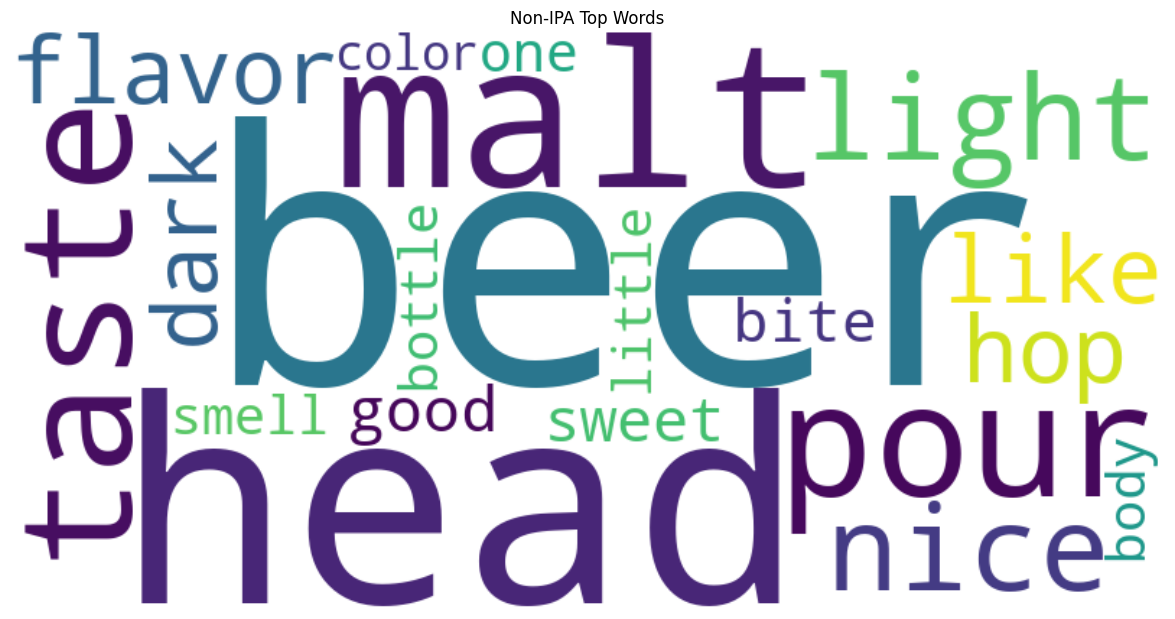

In [9]:
# Function to create word cloud
def create_wordcloud(word_freq, title=''):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
    plt.figure(figsize=(15, 7.5))
    plt.title(title)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Create word cloud for IPA top words
print("Word Cloud for IPA Top Words:")
create_wordcloud(ipa_top_words, title='IPA Top Words')

# Create word cloud for Non-IPA top words
print("Word Cloud for Non-IPA Top Words:")
create_wordcloud(non_ipa_top_words, title='Non-IPA Top Words')

## 8. Flavor Profile Analysis

In [10]:
# Define a list of common beer flavor descriptors
flavor_descriptors = [
    'hoppy', 'bitter', 'citrus', 'pine', 'floral', 'malty', 'sweet', 'roasted', 'caramel',
    'chocolate', 'coffee', 'fruit', 'spicy', 'herbal', 'earthy', 'toffee', 'tropical', 'yeast',
    'banana', 'clove', 'smoke', 'oak', 'vanilla', 'nutty', 'wheat', 'grain', 'sour', 'tart'
]

# Function to count flavor descriptors
def count_flavors(tokens_list, flavor_list):
    flavor_counts = dict.fromkeys(flavor_list, 0)
    for tokens in tokens_list:
        for token in tokens:
            if token in flavor_list:
                flavor_counts[token] += 1
    return flavor_counts

# Count flavors in IPA and Non-IPA reviews
ipa_flavor_counts = count_flavors(ipa_tokens_list, flavor_descriptors)
non_ipa_flavor_counts = count_flavors(non_ipa_tokens_list, flavor_descriptors)

# Convert to DataFrame
ipa_flavor_df = pd.DataFrame(list(ipa_flavor_counts.items()), columns=['Flavor', 'Count_IPA'])
non_ipa_flavor_df = pd.DataFrame(list(non_ipa_flavor_counts.items()), columns=['Flavor', 'Count_Non_IPA'])

## 9. Visualizing Flavor Profiles

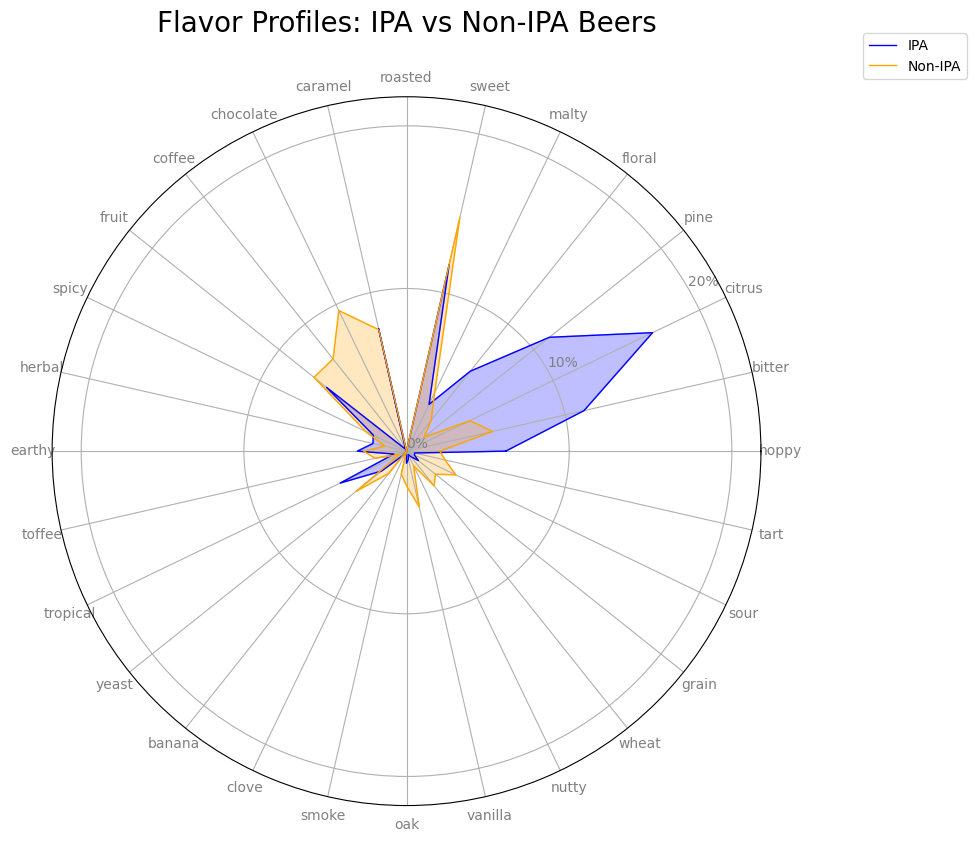

In [11]:
flavor_comparison_df = ipa_flavor_df.merge(non_ipa_flavor_df, on='Flavor')

flavors = flavor_comparison_df['Flavor']
ipa_counts = flavor_comparison_df['Count_IPA']
non_ipa_counts = flavor_comparison_df['Count_Non_IPA']

total_ipa = ipa_counts.sum()
total_non_ipa = non_ipa_counts.sum()
ipa_percentages = ipa_counts / total_ipa * 100
non_ipa_percentages = non_ipa_counts / total_non_ipa * 100

num_vars = len(flavors)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

angles += angles[:1]
ipa_percentages = ipa_percentages.tolist()
ipa_percentages += ipa_percentages[:1]
non_ipa_percentages = non_ipa_percentages.tolist()
non_ipa_percentages += non_ipa_percentages[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

plt.xticks(angles[:-1], flavors, color='grey', size=10)
ax.set_rlabel_position(30)
plt.yticks(range(0, int(max(max(ipa_percentages), max(non_ipa_percentages))) + 10, 10),
           [f"{i}%" for i in range(0, int(max(max(ipa_percentages), max(non_ipa_percentages))) + 10, 10)],
           color="grey", size=10)
plt.ylim(0, max(max(ipa_percentages), max(non_ipa_percentages)) + 5)

# Plot IPA data
ax.plot(angles, ipa_percentages, linewidth=1, linestyle='solid', label='IPA', color='blue')
ax.fill(angles, ipa_percentages, alpha=0.25, color='blue')

# Plot Non-IPA data
ax.plot(angles, non_ipa_percentages, linewidth=1, linestyle='solid', label='Non-IPA', color='orange')
ax.fill(angles, non_ipa_percentages, alpha=0.25, color='orange')

# Add title and legend
plt.title('Flavor Profiles: IPA vs Non-IPA Beers', size=20, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))

plt.tight_layout()
plt.show()

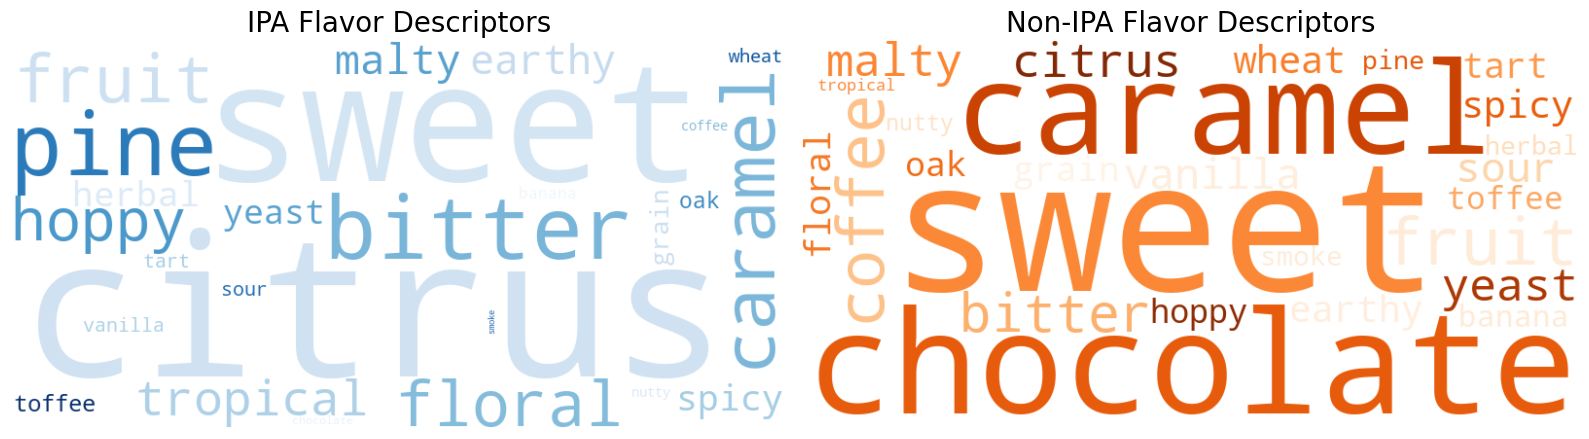

In [12]:
# Generate word cloud for IPA
ipa_word_freq = dict(zip(flavor_comparison_df['Flavor'], flavor_comparison_df['Count_IPA']))
ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Blues').generate_from_frequencies(ipa_word_freq)

# Generate word cloud for Non-IPA
non_ipa_word_freq = dict(zip(flavor_comparison_df['Flavor'], flavor_comparison_df['Count_Non_IPA']))
non_ipa_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Oranges').generate_from_frequencies(non_ipa_word_freq)

# Plot word clouds
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(ipa_wordcloud, interpolation='bilinear')
plt.title('IPA Flavor Descriptors', size=20)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(non_ipa_wordcloud, interpolation='bilinear')
plt.title('Non-IPA Flavor Descriptors', size=20)
plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\danil\AppData\Local\Temp\ipykernel_9316\1417076600.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


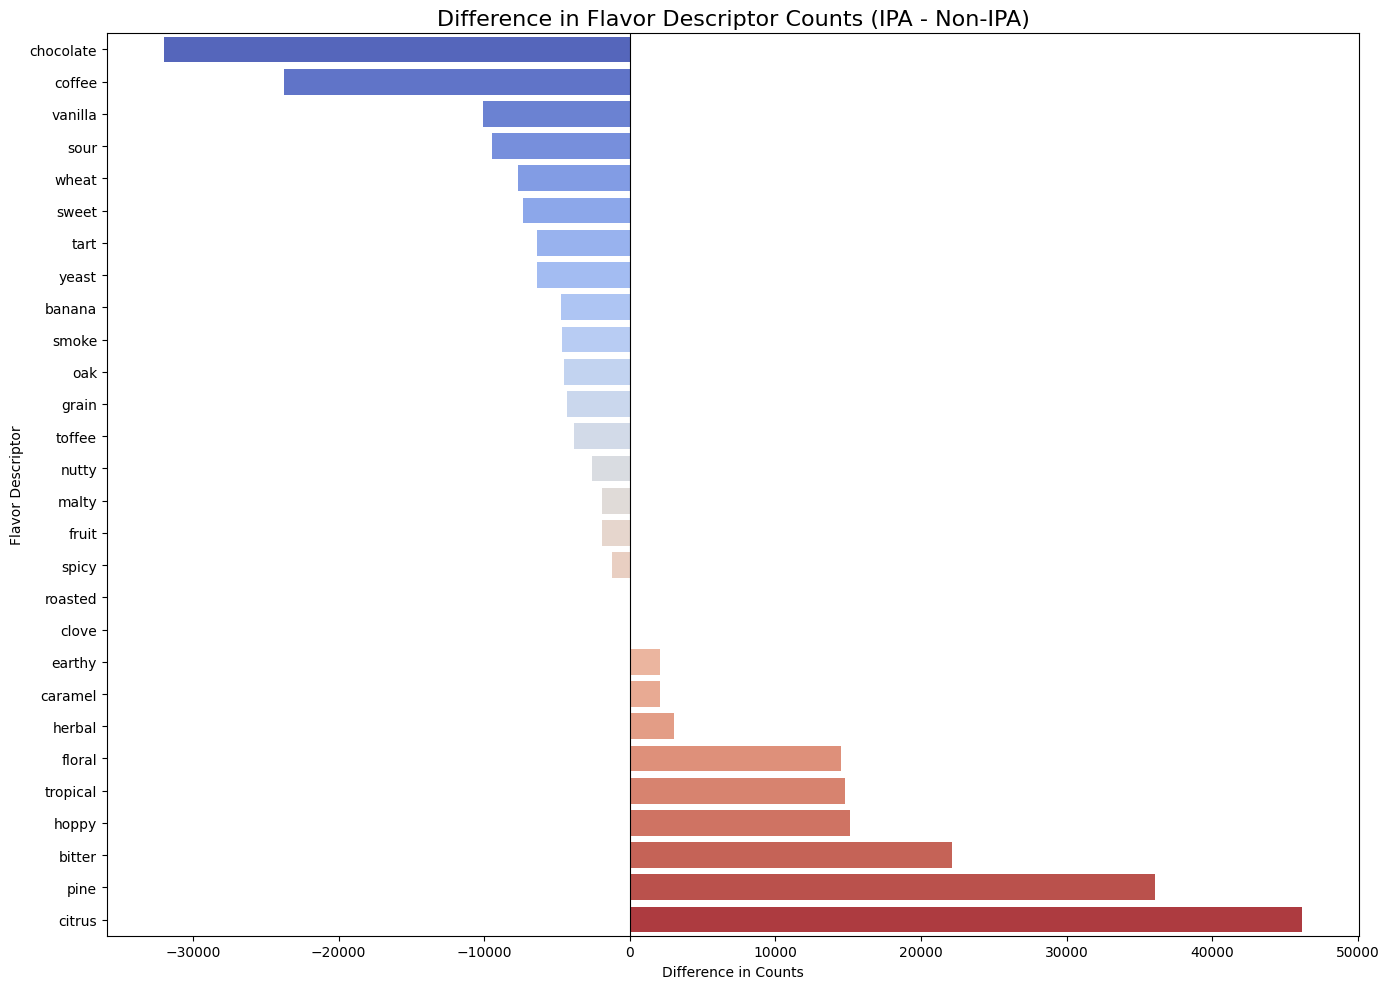

In [13]:
# Calculate difference in counts
flavor_comparison_df['Difference'] = flavor_comparison_df['Count_IPA'] - flavor_comparison_df['Count_Non_IPA']

# Sort by absolute difference
sorted_flavors = flavor_comparison_df.sort_values('Difference', ascending=True)

# Plot difference bar chart
plt.figure(figsize=(14, 10))
sns.barplot(
    data=sorted_flavors,
    x='Difference',
    y='Flavor',
    palette='coolwarm',
    orient='h'
)
plt.title('Difference in Flavor Descriptor Counts (IPA - Non-IPA)', size=16)
plt.xlabel('Difference in Counts')
plt.ylabel('Flavor Descriptor')
plt.axvline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()


## 10. Statistical Analysis

In [14]:
# Remove flavors where counts are zero in either IPA or Non-IPA
flavor_comparison_df_filtered = flavor_comparison_df[
    (flavor_comparison_df['Count_IPA'] > 0) & (flavor_comparison_df['Count_Non_IPA'] > 0)
].reset_index(drop=True)

# Prepare data for Chi-square test
chi2_data = flavor_comparison_df_filtered[['Count_IPA', 'Count_Non_IPA']].values

# Perform the Chi-square test
chi2_stat, p_val, dof, ex = chi2_contingency(chi2_data)

print(f"Chi-square Statistic: {chi2_stat:.4f}, p-value: {p_val:.4f}")

# Identify flavors with significant differences
flavor_comparison_df_filtered['IPA_Percentage'] = (
    flavor_comparison_df_filtered['Count_IPA'] / flavor_comparison_df_filtered['Count_IPA'].sum()
) * 100
flavor_comparison_df_filtered['Non_IPA_Percentage'] = (
    flavor_comparison_df_filtered['Count_Non_IPA'] / flavor_comparison_df_filtered['Count_Non_IPA'].sum()
) * 100
flavor_comparison_df_filtered['Difference'] = (
    flavor_comparison_df_filtered['IPA_Percentage'] - flavor_comparison_df_filtered['Non_IPA_Percentage']
)

# Flavors with the biggest differences
flavor_comparison_df_filtered['Abs_Difference'] = flavor_comparison_df_filtered['Difference'].abs()
significant_flavors = flavor_comparison_df_filtered.sort_values(
    'Abs_Difference', ascending=False
).reset_index(drop=True)

print("\nFlavors sorted by difference in usage between IPA and Non-IPA reviews:")
print(significant_flavors[['Flavor', 'IPA_Percentage', 'Non_IPA_Percentage', 'Difference']])

Chi-square Statistic: 186045.2861, p-value: 0.0000

Flavors sorted by difference in usage between IPA and Non-IPA reviews:
       Flavor  IPA_Percentage  Non_IPA_Percentage  Difference
0      citrus       16.789352            4.324241   12.465111
1        pine       11.227941            1.371741    9.856201
2   chocolate        0.150644            9.595406   -9.444762
3      coffee        0.239761            7.246966   -7.007205
4      bitter       11.193453            5.432719    5.760734
5       hoppy        6.101080            2.054811    4.046270
6    tropical        4.531183            0.487317    4.043865
7      floral        6.288144            2.435113    3.853031
8     vanilla        0.513459            3.520006   -3.006547
9       sweet       11.785821           14.754838   -2.969017
10       sour        0.531392            3.363758   -2.832365
11      wheat        0.442551            2.728447   -2.285895
12      yeast        1.960855            3.969293   -2.008438
13       

### 10.1 Statistical Significance of Individual Flavors

In [15]:
# Function to perform Chi-square test for individual flavors
def chi_square_individual_flavor(counts_ipa, counts_non_ipa):
    observed = np.array([counts_ipa, counts_non_ipa])
    total = observed.sum()
    expected = np.array([
        (observed.sum(axis=0) * observed.sum(axis=1)[0]) / total,
        (observed.sum(axis=0) * observed.sum(axis=1)[1]) / total
    ])
    chi2_stat = ((observed - expected) ** 2 / expected).sum()
    p_value = chi2.sf(chi2_stat, df=1)
    return chi2_stat, p_value

# Perform Chi-square test for each flavor
significant_flavors['Chi2_Stat'] = 0.0
significant_flavors['P_Value'] = 0.0

for idx, row in significant_flavors.iterrows():
    obs = np.array([
        [row['Count_IPA'], flavor_comparison_df_filtered['Count_IPA'].sum() - row['Count_IPA']],
        [row['Count_Non_IPA'], flavor_comparison_df_filtered['Count_Non_IPA'].sum() - row['Count_Non_IPA']]
    ])
    chi2_stat, p_value, _, _ = chi2_contingency(obs)
    significant_flavors.loc[idx, 'Chi2_Stat'] = chi2_stat
    significant_flavors.loc[idx, 'P_Value'] = p_value

# Adjust p-values for multiple comparisons using Bonferroni correction
significant_flavors['Adjusted_P_Value'] = significant_flavors['P_Value'] * len(significant_flavors)
significant_flavors['Significant'] = significant_flavors['Adjusted_P_Value'] < 0.05

print("\nSignificant flavors after Bonferroni correction:")
print(significant_flavors[['Flavor', 'Chi2_Stat', 'Adjusted_P_Value', 'Significant']])


Significant flavors after Bonferroni correction:
       Flavor     Chi2_Stat  Adjusted_P_Value  Significant
0      citrus  28344.478334      0.000000e+00         True
1        pine  28154.935858      0.000000e+00         True
2   chocolate  34776.925766      0.000000e+00         True
3      coffee  24609.193759      0.000000e+00         True
4      bitter   7549.567028      0.000000e+00         True
5       hoppy   7219.317055      0.000000e+00         True
6    tropical  11414.756685      0.000000e+00         True
7      floral   6149.285496      0.000000e+00         True
8     vanilla   8212.442240      0.000000e+00         True
9       sweet   1345.987774     2.982217e-293         True
10       sour   7537.393500      0.000000e+00         True
11      wheat   6007.450823      0.000000e+00         True
12      yeast   2482.921962      0.000000e+00         True
13       tart   4538.076806      0.000000e+00         True
14     banana   3528.857618      0.000000e+00         True
15    

### 10.2 Visualization of Significant Flavors

C:\Users\danil\AppData\Local\Temp\ipykernel_9316\154065182.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


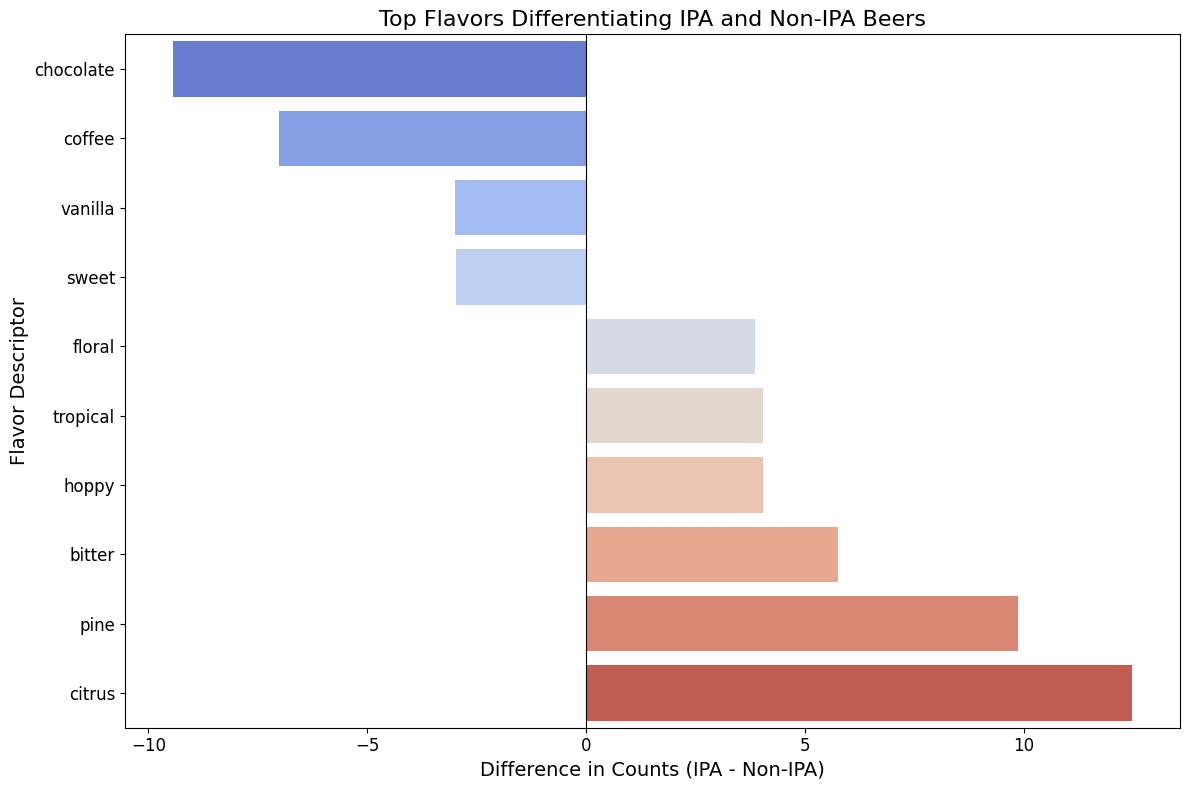

In [16]:
# Plotting significant flavors
top_flavors_melted = significant_flavors.head(10).melt(
    id_vars='Flavor',
    value_vars=['Count_IPA', 'Count_Non_IPA'],
    var_name='Beer_Type',
    value_name='Count'
)
top_flavors_melted['Beer_Type'] = top_flavors_melted['Beer_Type'].str.replace('Count_', '')

# Select the top 10 flavors with the largest absolute differences
top_flavors = significant_flavors.copy()
top_flavors['Abs_Difference'] = top_flavors['Difference'].abs()
top_flavors = top_flavors.sort_values('Abs_Difference', ascending=False).head(10)

# Sort flavors for better visualization
top_flavors = top_flavors.sort_values('Difference', ascending=True)

# Plot divergent bar chart
plt.figure(figsize=(12, 8))
sns.barplot(
    data=top_flavors,
    x='Difference',
    y='Flavor',
    palette='coolwarm',
    orient='h'
)
plt.title('Top Flavors Differentiating IPA and Non-IPA Beers', fontsize=16)
plt.xlabel('Difference in Counts (IPA - Non-IPA)', fontsize=14)
plt.ylabel('Flavor Descriptor', fontsize=14)
plt.axvline(0, color='black', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [17]:
import plotly.express as px

# Prepare data
top_flavors_plotly = top_flavors.copy()
top_flavors_plotly['Flavor'] = top_flavors_plotly['Flavor'].astype(str)

# Create interactive divergent bar chart
fig = px.bar(
    top_flavors_plotly,
    x='Difference',
    y='Flavor',
    orientation='h',
    color='Difference',
    color_continuous_scale='Tealrose',
    title='Top Flavors Differentiating IPA and Non-IPA Beers',
    labels={'Difference': 'Difference in Counts (IPA - Non-IPA)', 'Flavor': 'Flavor Descriptor'},
    height=600,
)

# Update layout for better appearance
fig.update_layout(
    xaxis_title='Difference in Counts (IPA - Non-IPA)',
    yaxis_title='Flavor Descriptor',
    coloraxis_showscale=False,
    plot_bgcolor='white',
    font=dict(size=12),
)
fig.add_vline(x=0, line_width=1, line_color='black')

# Show interactive plot
fig.show()

## 11. Sentiment Analysis using VADER

In [18]:
# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Function to compute sentiments
def compute_sentiments(texts):
    sentiments = [sia.polarity_scores(text)['compound'] for text in texts]
    return sentiments

# Compute sentiments for IPA reviews
ipa_reviews_filtered['compound_sentiment'] = compute_sentiments(ipa_reviews_filtered['text'])

# Compute sentiments for Non-IPA reviews
non_ipa_reviews_filtered['compound_sentiment'] = compute_sentiments(non_ipa_reviews_filtered['text'])

## 12. Calculating Sentiment and Rating Variance and Standard Deviation

In [19]:
# Calculate sentiment variance and standard deviation for IPA beers
ipa_sentiment_stats = ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].agg(['var', 'std', 'median']).reset_index()
ipa_sentiment_stats.rename(columns={'var': 'sentiment_variance', 'std': 'sentiment_std', 'median': 'sentiment_median'}, inplace=True)
ipa_sentiment_stats['beer_type'] = 'IPA'

# Calculate sentiment variance and standard deviation for Non-IPA beers
non_ipa_sentiment_stats = non_ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].agg(['var', 'std', 'median']).reset_index()
non_ipa_sentiment_stats.rename(columns={'var': 'sentiment_variance', 'std': 'sentiment_std', 'median': 'sentiment_median'}, inplace=True)
non_ipa_sentiment_stats['beer_type'] = 'Non-IPA'

# Combine sentiment stats data
combined_sentiment_stats = pd.concat([ipa_sentiment_stats, non_ipa_sentiment_stats], ignore_index=True)

# Calculate rating variance and standard deviation for IPA beers
ipa_rating_stats = ipa_reviews_filtered.groupby('beer_id')['rating'].agg(['var', 'std', 'median']).reset_index()
ipa_rating_stats.rename(columns={'var': 'rating_variance', 'std': 'rating_std', 'median': 'rating_median'}, inplace=True)
ipa_rating_stats['beer_type'] = 'IPA'

# Calculate rating variance and standard deviation for Non-IPA beers
non_ipa_rating_stats = non_ipa_reviews_filtered.groupby('beer_id')['rating'].agg(['var', 'std', 'median']).reset_index()
non_ipa_rating_stats.rename(columns={'var': 'rating_variance', 'std': 'rating_std', 'median': 'rating_median'}, inplace=True)
non_ipa_rating_stats['beer_type'] = 'Non-IPA'

# Combine rating stats data
combined_rating_stats = pd.concat([ipa_rating_stats, non_ipa_rating_stats], ignore_index=True)

## 13. Calculating Entropy of Ratings and Sentiments

In [20]:
# Function to calculate entropy
def calculate_entropy(values):
    hist, bin_edges = np.histogram(values, bins=10, range=(0, 1), density=True)
    hist = hist[hist > 0]
    return entropy(hist)

# Calculate entropy for sentiment scores
ipa_entropy_sentiment = ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].apply(calculate_entropy).reset_index(name='sentiment_entropy')
ipa_entropy_sentiment['beer_type'] = 'IPA'

non_ipa_entropy_sentiment = non_ipa_reviews_filtered.groupby('beer_id')['compound_sentiment'].apply(calculate_entropy).reset_index(name='sentiment_entropy')
non_ipa_entropy_sentiment['beer_type'] = 'Non-IPA'

combined_entropy_sentiment = pd.concat([ipa_entropy_sentiment, non_ipa_entropy_sentiment], ignore_index=True)

# Calculate entropy for ratings
ipa_entropy_rating = ipa_reviews_filtered.groupby('beer_id')['rating'].apply(calculate_entropy).reset_index(name='rating_entropy')
ipa_entropy_rating['beer_type'] = 'IPA'

non_ipa_entropy_rating = non_ipa_reviews_filtered.groupby('beer_id')['rating'].apply(calculate_entropy).reset_index(name='rating_entropy')
non_ipa_entropy_rating['beer_type'] = 'Non-IPA'

combined_entropy_rating = pd.concat([ipa_entropy_rating, non_ipa_entropy_rating], ignore_index=True)

c:\Users\danil\Documents\Github\ada-2024-project-data-crusadas\venv310\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning:

invalid value encountered in divide

c:\Users\danil\Documents\Github\ada-2024-project-data-crusadas\venv310\lib\site-packages\numpy\lib\histograms.py:883: RuntimeWarning:

invalid value encountered in divide



## 14. Visualizations of Variance, Standard Deviation, and Entropy

### 14.1 Box Plots for Rating Variance and Standard Deviation

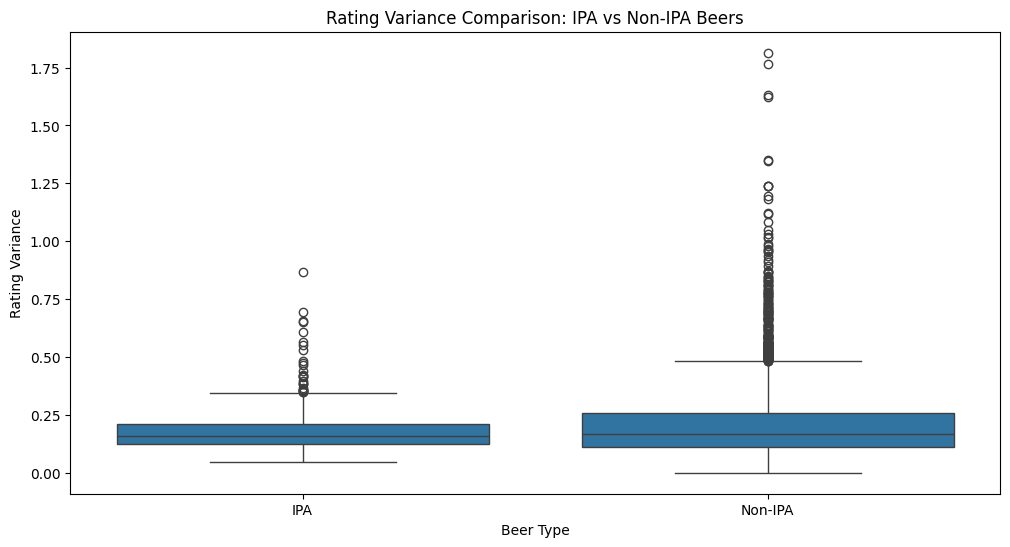

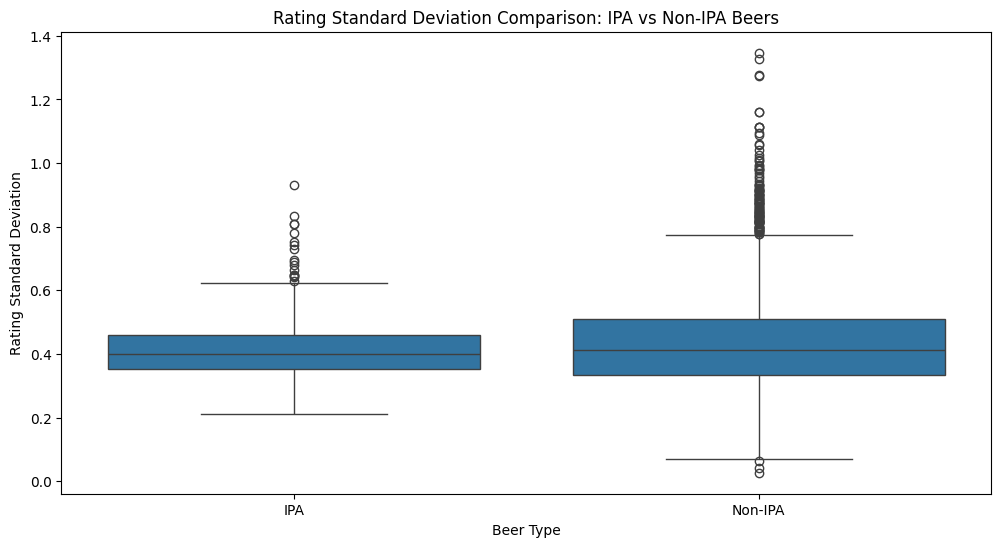

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_rating_stats, x='beer_type', y='rating_variance')
plt.title('Rating Variance Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Rating Variance')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_rating_stats, x='beer_type', y='rating_std')
plt.title('Rating Standard Deviation Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Rating Standard Deviation')
plt.show()

### 14.2 Violin Plots for Sentiment Variance and Standard Deviation

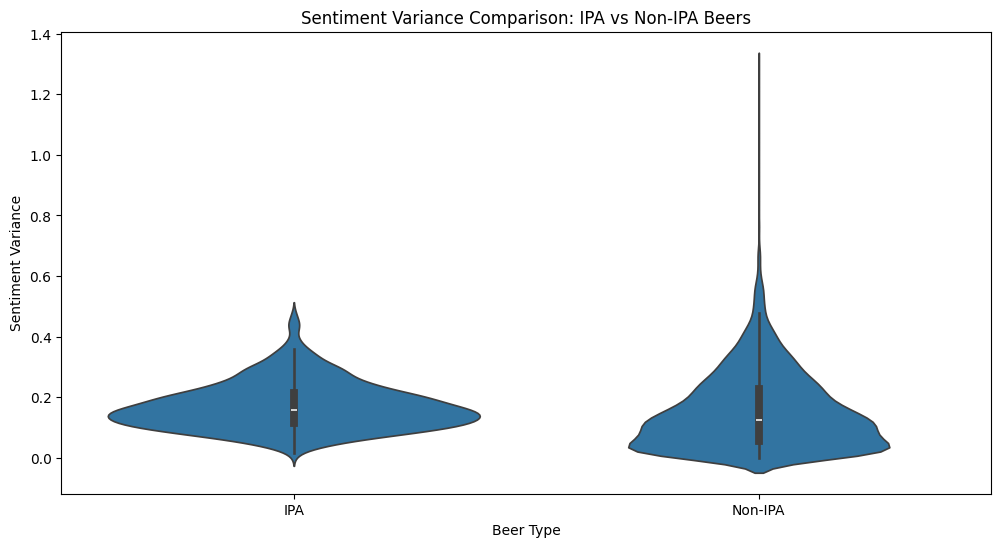

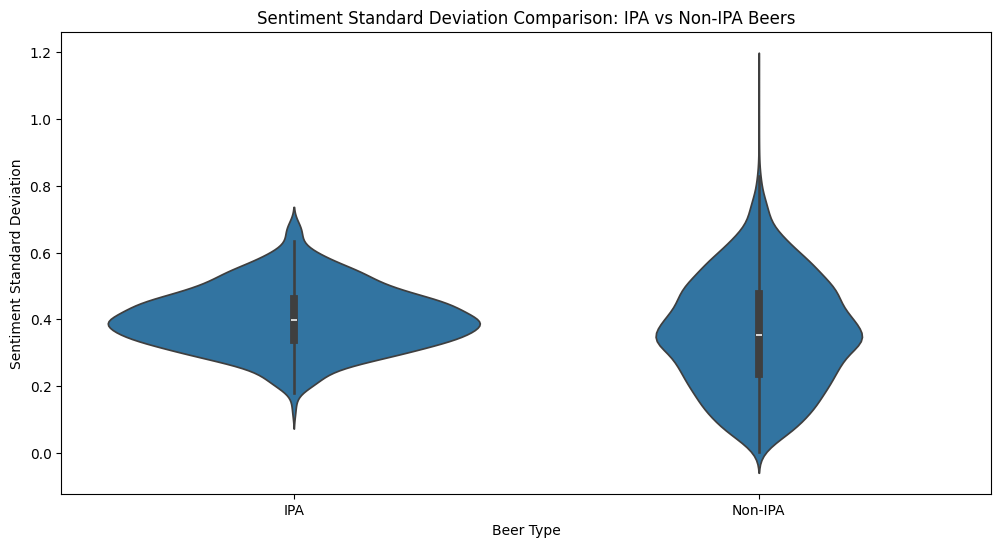

In [22]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_sentiment_stats, x='beer_type', y='sentiment_variance')
plt.title('Sentiment Variance Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Sentiment Variance')
plt.show()

plt.figure(figsize=(12, 6))
sns.violinplot(data=combined_sentiment_stats, x='beer_type', y='sentiment_std')
plt.title('Sentiment Standard Deviation Comparison: IPA vs Non-IPA Beers')
plt.xlabel('Beer Type')
plt.ylabel('Sentiment Standard Deviation')
plt.show()

### 14.3 CDF Plots for Rating and Sentiment Entropy

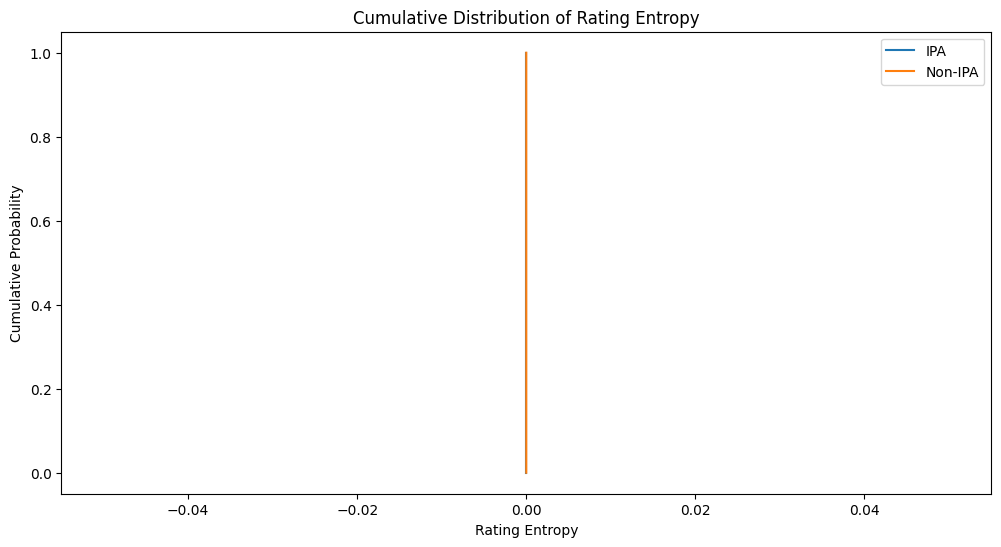

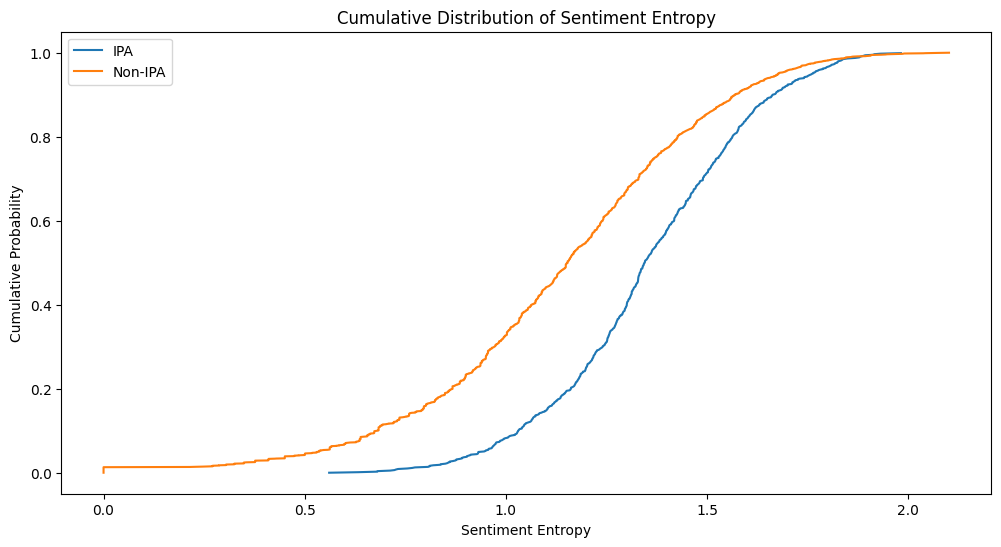

In [23]:
# Rating Entropy CDF
plt.figure(figsize=(12, 6))
for beer_type, group_data in combined_entropy_rating.groupby('beer_type'):
    sorted_data = np.sort(group_data['rating_entropy'].dropna())
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=beer_type)
plt.title('Cumulative Distribution of Rating Entropy')
plt.xlabel('Rating Entropy')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

# Sentiment Entropy CDF
plt.figure(figsize=(12, 6))
for beer_type, group_data in combined_entropy_sentiment.groupby('beer_type'):
    sorted_data = np.sort(group_data['sentiment_entropy'].dropna())
    yvals = np.arange(len(sorted_data))/float(len(sorted_data))
    plt.plot(sorted_data, yvals, label=beer_type)
plt.title('Cumulative Distribution of Sentiment Entropy')
plt.xlabel('Sentiment Entropy')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

### 14.4 Clustering Analysis on Embeddings

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
model = AutoModel.from_pretrained('distilbert-base-uncased')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [ ]:
def compute_embeddings_batch(texts, batch_size=32):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()
        embeddings.append(batch_embeddings)
    embeddings = np.vstack(embeddings)
    return embeddings

# Compute embeddings for IPA reviews
if 'embedding' not in ipa_reviews_filtered.columns:
    print("Computing embeddings for IPA reviews...")
    ipa_embeddings = compute_embeddings_batch(ipa_reviews_filtered['text'].tolist())
    ipa_reviews_filtered['embedding'] = list(ipa_embeddings)
else:
    print("Embeddings for IPA reviews already exist.")

# Compute embeddings for Non-IPA reviews
if 'embedding' not in non_ipa_reviews_filtered.columns:
    print("Computing embeddings for Non-IPA reviews...")
    non_ipa_embeddings = compute_embeddings_batch(non_ipa_reviews_filtered['text'].tolist())
    non_ipa_reviews_filtered['embedding'] = list(non_ipa_embeddings)
else:
    print("Embeddings for Non-IPA reviews already exist.")

Computing embeddings for IPA reviews...


100%|██████████| 3125/3125 [14:54<00:00,  3.49it/s]


Computing embeddings for Non-IPA reviews...


100%|██████████| 3125/3125 [15:23<00:00,  3.38it/s]


In [ ]:
def calculate_agreement(embeddings_list):
    embeddings = np.vstack(embeddings_list)
    if embeddings.shape[0] < 2:
        return np.nan  # Cannot compute pairwise distances with less than 2 embeddings
    pairwise_distances = pdist(embeddings, metric='cosine')
    pairwise_similarities = 1 - pairwise_distances
    avg_similarity = np.mean(pairwise_similarities)
    return avg_similarity

# Group by beer_id and calculate agreement for IPA beers
ipa_beer_agreement = ipa_reviews_filtered.groupby('beer_id')['embedding'].apply(list).reset_index()
ipa_beer_agreement['avg_similarity'] = ipa_beer_agreement['embedding'].progress_apply(calculate_agreement)
ipa_beer_agreement = ipa_beer_agreement.merge(ba_beers_df[['beer_id', 'beer_name']], on='beer_id', how='left')
ipa_beer_agreement['beer_type'] = 'IPA'

# Group by beer_id and calculate agreement for Non-IPA beers
non_ipa_beer_agreement = non_ipa_reviews_filtered.groupby('beer_id')['embedding'].apply(list).reset_index()
non_ipa_beer_agreement['avg_similarity'] = non_ipa_beer_agreement['embedding'].progress_apply(calculate_agreement)
non_ipa_beer_agreement = non_ipa_beer_agreement.merge(ba_beers_df[['beer_id', 'beer_name']], on='beer_id', how='left')
non_ipa_beer_agreement['beer_type'] = 'Non-IPA'

# Combine IPA and Non-IPA agreement scores
combined_agreement = pd.concat([ipa_beer_agreement, non_ipa_beer_agreement], ignore_index=True)

100%|██████████| 3794/3794 [00:01<00:00, 2011.73it/s]


In [ ]:
# sample a subset
sample_size = 30000
ipa_sample_embeddings = ipa_reviews_filtered.sample(n=sample_size, random_state=42).reset_index(drop=True)
non_ipa_sample_embeddings = non_ipa_reviews_filtered.sample(n=sample_size, random_state=42).reset_index(drop=True)

def compute_embeddings_if_needed(df):
    if 'embedding' not in df.columns:
        print("Computing embeddings...")
        embeddings = compute_embeddings_batch(df['text'].tolist())
        df['embedding'] = list(embeddings)
    return df

ipa_sample_embeddings = compute_embeddings_if_needed(ipa_sample_embeddings)
non_ipa_sample_embeddings = compute_embeddings_if_needed(non_ipa_sample_embeddings)

combined_embeddings_df = pd.concat([ipa_sample_embeddings, non_ipa_sample_embeddings], ignore_index=True)
combined_embeddings_df['beer_type'] = ['IPA'] * len(ipa_sample_embeddings) + ['Non-IPA'] * len(non_ipa_sample_embeddings)

all_embeddings = np.vstack(combined_embeddings_df['embedding'].values)

Silhouette Score for KMeans Clustering: 0.0403


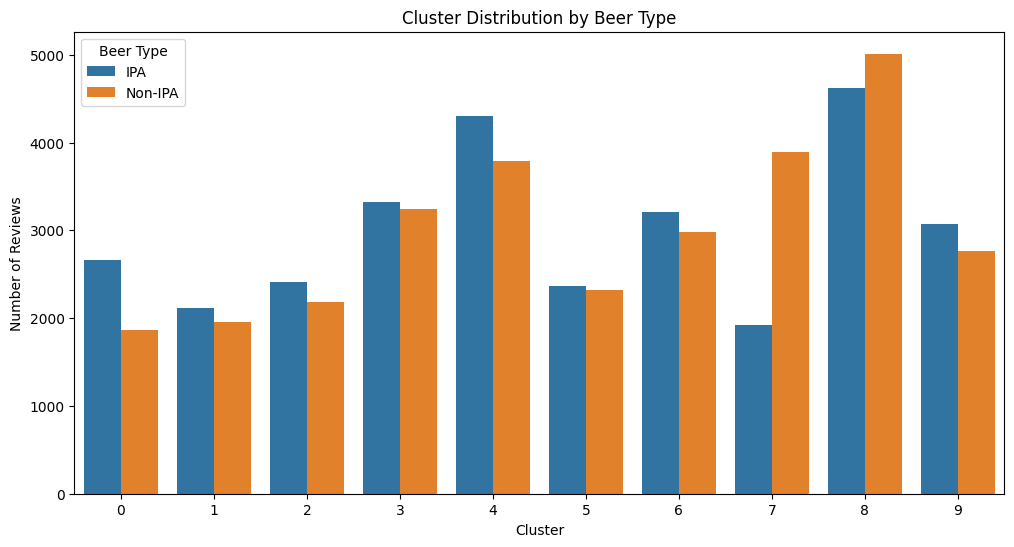

In [ ]:
# KMeans clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(all_embeddings)
combined_embeddings_df['cluster'] = cluster_labels

# Calculate silhouette scores
silhouette_avg = silhouette_score(all_embeddings, cluster_labels)
print(f"Silhouette Score for KMeans Clustering: {silhouette_avg:.4f}")

# Compare cluster distributions between IPA and Non-IPA
cluster_counts = combined_embeddings_df.groupby(['beer_type', 'cluster']).size().reset_index(name='counts')

# Plot cluster distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=cluster_counts, x='cluster', y='counts', hue='beer_type')
plt.title('Cluster Distribution by Beer Type')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.legend(title='Beer Type')
plt.show()

## 15. Statistical Tests

In [29]:
# Use Mann-Whitney U Test for non-parametric comparison

# Rating Variance
u_stat_rating, p_value_rating = mannwhitneyu(
    ipa_rating_stats['rating_variance'].dropna(),
    non_ipa_rating_stats['rating_variance'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U Test for Rating Variance: U = {u_stat_rating}, p-value = {p_value_rating:.4f}")

# Sentiment Variance
u_stat_sentiment, p_value_sentiment = mannwhitneyu(
    ipa_sentiment_stats['sentiment_variance'].dropna(),
    non_ipa_sentiment_stats['sentiment_variance'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U Test for Sentiment Variance: U = {u_stat_sentiment}, p-value = {p_value_sentiment:.4f}")

# Rating Entropy
u_stat_rating_entropy, p_value_rating_entropy = mannwhitneyu(
    ipa_entropy_rating['rating_entropy'].dropna(),
    non_ipa_entropy_rating['rating_entropy'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U Test for Rating Entropy: U = {u_stat_rating_entropy}, p-value = {p_value_rating_entropy:.4f}")

# Sentiment Entropy
u_stat_sentiment_entropy, p_value_sentiment_entropy = mannwhitneyu(
    ipa_entropy_sentiment['sentiment_entropy'].dropna(),
    non_ipa_entropy_sentiment['sentiment_entropy'].dropna(),
    alternative='two-sided'
)
print(f"Mann-Whitney U Test for Sentiment Entropy: U = {u_stat_sentiment_entropy}, p-value = {p_value_sentiment_entropy:.4f}")

# Kolmogorov-Smirnov Test for Agreement Scores
ks_stat_agreement, p_value_agreement = ks_2samp(
    ipa_beer_agreement['avg_similarity'].dropna(),
    non_ipa_beer_agreement['avg_similarity'].dropna()
)
print(f"Kolmogorov-Smirnov Test for Agreement Scores: KS Statistic = {ks_stat_agreement:.4f}, p-value = {p_value_agreement:.4f}")

Mann-Whitney U Test for Rating Variance: U = 1410196.0, p-value = 0.0096
Mann-Whitney U Test for Sentiment Variance: U = 1781407.0, p-value = 0.0000
Mann-Whitney U Test for Rating Entropy: U = 1498630.0, p-value = 1.0000
Mann-Whitney U Test for Sentiment Entropy: U = 2068648.0, p-value = 0.0000
Kolmogorov-Smirnov Test for Agreement Scores: KS Statistic = 0.1703, p-value = 0.0000


### 15.1 Effect Sizes

In [30]:
# Compute effect size (Cohen's d) for rating variance
def cohen_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx -1)*np.var(x, ddof=1) + (ny -1)*np.var(y, ddof=1)) / dof)

d_rating_variance = cohen_d(ipa_rating_stats['rating_variance'].dropna(), non_ipa_rating_stats['rating_variance'].dropna())
print(f"Cohen's d for Rating Variance: {d_rating_variance:.4f}")

d_sentiment_variance = cohen_d(ipa_sentiment_stats['sentiment_variance'].dropna(), non_ipa_sentiment_stats['sentiment_variance'].dropna())
print(f"Cohen's d for Sentiment Variance: {d_sentiment_variance:.4f}")

Cohen's d for Rating Variance: -0.2326
Cohen's d for Sentiment Variance: 0.1368
